# Image Preprocessing Pipeline Demo

This notebook demonstrates step-by-step how to execute the image preprocessing pipeline.  
It loads an example image, applies the defined pipeline, and displays the before‑and‑after results.


In [1]:
# tested in python >= 3.12, < 3.13, use main pyproject.toml
import sys
import os

# En notebooks usamos os.getcwd() en lugar de __file__
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [4]:
import cv2 
import matplotlib.pyplot as plt
from lib.image.pipeline import process_image

## Summary

This preprocessing pipeline comprises a sequence of modular functions that `(1) deskew scanned images`, `(2) remove noise`, `(3) normalize brightness and contrast`, `(4) resize to a standard width`, `(5) enhance local contrast`, `(6) crop away empty borders`, `(7) generate an edge‑difference map`, `(8) extract embedded text`, `(9) record provenance metadata`, and `(10) compute a Keccak‑256 hash` to cryptographically “stamp” each processed image, ensuring both visual consistency and verifiable integrity.

## Pipeline Modular Configuration 

```python
# Pipeline configuration
PIPELINE_STEPS = [
    correct_image_rotation,
    make_denoise(10, 7),
    lambda img: adjust_brightness_contrast(img, alpha=1.2, beta=10),
    resize_image,
    normalize_image,
    auto_crop
]
```

## Brief Function Explanations

1. **correct_image_rotation**  
   Automatically straightens tilted document scans by binarizing via Otsu’s method, finding the minimum-area bounding rectangle of the foreground, and applying an affine rotation to align text horizontally.  
   **References:** [Medium](https://medium.com), [Stack Overflow](https://stackoverflow.com).

2. **make_denoise / Denoising**  
   Uses Non-Local Means filtering to suppress random noise while preserving crucial edge details, by averaging pixels with similar neighborhood patterns across the image.  
   **References:** [OpenCV Documentation](https://docs.opencv.org), [amroamroamro.github.io](https://amroamroamro.github.io).

3. **adjust_brightness_contrast**  
   Applies a linear intensity transform (output = α·input + β) via `cv2.convertScaleAbs()`, standardizing exposure and contrast across all images for greater visual uniformity.  
   **References:** [TutorialsPoint](https://www.tutorialspoint.com), [OpenCV Documentation](https://docs.opencv.org).

4. **resize_image**  
   Rescales the image to a fixed width (e.g., 1024 px) while maintaining its aspect ratio, using area-based interpolation to avoid distortion and ensure consistent dimensions.  
   **References:** [PyImageSearch](https://pyimagesearch.com), [Stack Overflow](https://stackoverflow.com).

5. **normalize_image (CLAHE)**  
   Enhances local contrast by dividing the image into contextual tiles and applying Contrast Limited Adaptive Histogram Equalization (CLAHE), thereby boosting detail in both dark and bright regions without over-amplifying noise.  
   **References:** [GeeksforGeeks](https://www.geeksforgeeks.org), [PyImageSearch](https://pyimagesearch.com).

6. **auto_crop**  
   Removes blank margins by applying Otsu’s thresholding to separate foreground from background and cropping to the bounding box of foreground pixels, producing a tightly framed content area.  
   **References:** [OpenCV Documentation](https://docs.opencv.org), [LearnOpenCV](https://learnopencv.com).

7. **detect_edges**  
   Generates a simple edge map using Canny edge detection, highlighting regions of high gradient that can later serve as a “difference mask” to illustrate pixel-level changes introduced during processing.  
   **References:** [OpenCV Documentation](https://docs.opencv.org), [GeeksforGeeks](https://www.geeksforgeeks.org).

8. **extract_text_from_image**  
   Leverages Pytesseract, a Python wrapper for the Tesseract-OCR engine, to convert visible text in the image into editable string data, enabling semantic analysis of embedded labels or annotations.  
   **References:** [AI Document Processing](https://ai.googleblog.com), [Stack Overflow](https://stackoverflow.com).

9. **generate_metadata**  
   Assembles a structured record of each processing step—such as input/output dimensions, blur detection flags, and applied parameters—providing provenance metadata that supports reproducibility and auditing.  
   **References:** [LDFI](https://ldfi.io), [exterro.com](https://www.exterro.com).

10. **keccak_image_hash**  
    Encodes the final processed image (e.g., as PNG bytes) and computes a Keccak-256 digest—a cryptographic hash standard used in blockchain systems—to produce a unique, tamper-evident fingerprint for each image.  
    **References:** [GeeksforGeeks](https://www.geeksforgeeks.org), [ethereum.stackexchange.com](https://ethereum.stackexchange.com).


## Image preprocessing + metadata parsing

```python
def process_image(image_path, steps=None):
    """
    Process an image using a series of image processing steps and return results.
    Args:
        image_path (str): The path to the input image.
        steps (list): A list of functions to apply to the image.
    Returns:
        dict: Contains original image, processed image, metadata, history, and hash.
    """
    orig = cv2.imread(image_path)
    if orig is None:
        raise ValueError(f"No se pudo cargar {image_path}")

    image = orig.copy()
    history = []
    metadata = {}
    if steps is None:
        steps = PIPELINE_STEPS

    for step in steps:
        try:
            prev = image.copy()
            image = step(image)
            metadata[step.__name__] = {
                "input_shape": prev.shape,
                "output_shape": image.shape
            }
            history.append(f"{step.__name__} applied")
        except Exception as e:
            history.append(f"{step.__name__} failed: {e}")

    # Compute final metadata and hash
    metadata.update(generate_metadata(orig, image))
    img_hash = keccak_image_hash(image)
    metadata["hash"] = img_hash
    history.append(f"hash computed: {img_hash[:8]}…")

    return {
        "original": orig,
        "processed": image,
        "metadata": metadata,
        "history": history
    }
```

## Rotated images

In [8]:
# Load and process an example image
image_dir = os.path.join(project_root, 'samples', 'data', 'images', 'img_pipeline')

In [9]:
#image1
image1_path = 'rotated.jpg'
image1_path = os.path.join(image_dir, image1_path)

result1 = process_image(image1_path)

orig1 = result1['original']
proc1 = result1['processed']

In [10]:
# image2
image2_path = 'rotated2.jpg'
image2_path = os.path.join(image_dir, image2_path)

result2 = process_image(image2_path)

orig2 = result2['original']
proc2 = result2['processed']

In [11]:
image3_path = 'blurred.webp'
image3_path = os.path.join(image_dir, image3_path)

result3 = process_image(image3_path)

orig3 = result3['original']
proc3 = result3['processed']

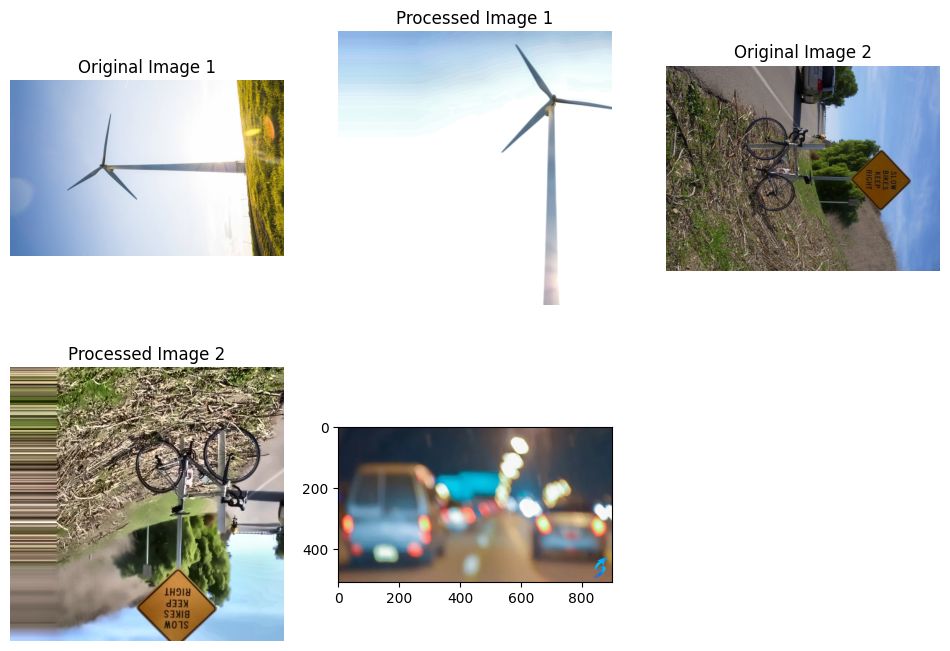

In [12]:
# display the images
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(orig1, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(proc1, cv2.COLOR_BGR2RGB))
plt.title('Processed Image 1')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(orig2, cv2.COLOR_BGR2RGB))
plt.title('Original Image 2')
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(proc2, cv2.COLOR_BGR2RGB))
plt.title('Processed Image 2')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(orig3, cv2.COLOR_BGR2RGB))



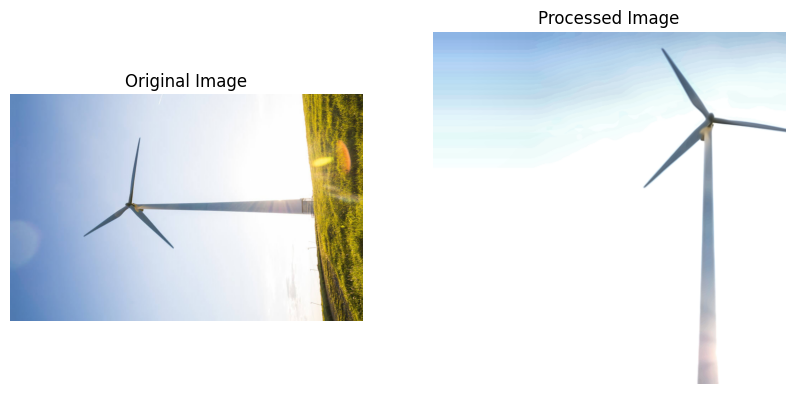

In [13]:
# Display original vs processed images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(orig1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Processed Image')
plt.imshow(cv2.cvtColor(proc1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


In [14]:
# View metadata and processing history
import pprint
pprint.pprint(result1['metadata'])

print('\nProcessing history:')
for step in result1['history']:
    print('-', step)


{'<lambda>': {'input_shape': (640, 993, 3), 'output_shape': (640, 993, 3)},
 'auto_crop': {'input_shape': (659, 1024, 3), 'output_shape': (659, 659, 3)},
 'correct_image_rotation': {'input_shape': (640, 993, 3),
                            'output_shape': (640, 993, 3)},
 'denoise_h10': {'input_shape': (640, 993, 3), 'output_shape': (640, 993, 3)},
 'hash': 'c31c30063684cc0340c6d3aa3777cf9a3c0d8dd9a5246f558da69b6d97c21eb1',
 'is_blurry': np.False_,
 'normalize_image': {'input_shape': (659, 1024, 3),
                     'output_shape': (659, 1024, 3)},
 'original_size': (640, 993, 3),
 'processed_size': (659, 659, 3),
 'resize_image': {'input_shape': (640, 993, 3), 'output_shape': (659, 1024, 3)}}

Processing history:
- correct_image_rotation applied
- denoise_h10 applied
- <lambda> applied
- resize_image applied
- normalize_image applied
- auto_crop applied
- hash computed: c31c3006…


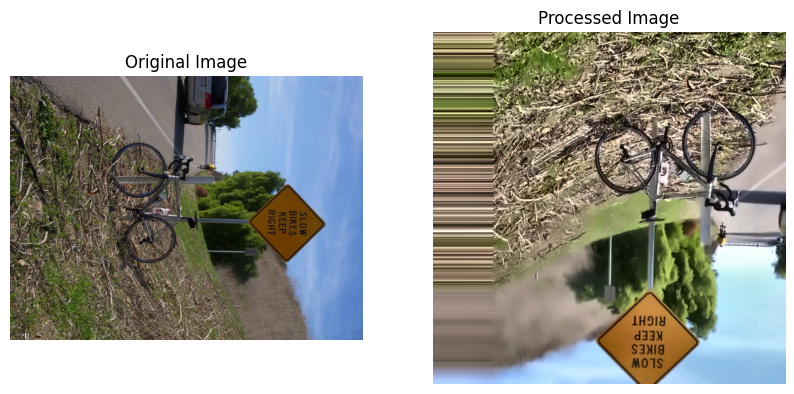

In [15]:
# Display original vs processed images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(orig2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Processed Image')
plt.imshow(cv2.cvtColor(proc2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [16]:
# View metadata and processing history
import pprint
pprint.pprint(result2['metadata'])

print('\nProcessing history:')
for step in result2['history']:
    print('-', step)


{'<lambda>': {'input_shape': (600, 800, 3), 'output_shape': (600, 800, 3)},
 'auto_crop': {'input_shape': (768, 1024, 3), 'output_shape': (768, 768, 3)},
 'correct_image_rotation': {'input_shape': (600, 800, 3),
                            'output_shape': (600, 800, 3)},
 'denoise_h10': {'input_shape': (600, 800, 3), 'output_shape': (600, 800, 3)},
 'hash': '438e27d5760b9cd2976c75ee3ec9f85027fe1b8e4e25c77b0c61915d4c17f48f',
 'is_blurry': np.False_,
 'normalize_image': {'input_shape': (768, 1024, 3),
                     'output_shape': (768, 1024, 3)},
 'original_size': (600, 800, 3),
 'processed_size': (768, 768, 3),
 'resize_image': {'input_shape': (600, 800, 3), 'output_shape': (768, 1024, 3)}}

Processing history:
- correct_image_rotation applied
- denoise_h10 applied
- <lambda> applied
- resize_image applied
- normalize_image applied
- auto_crop applied
- hash computed: 438e27d5…


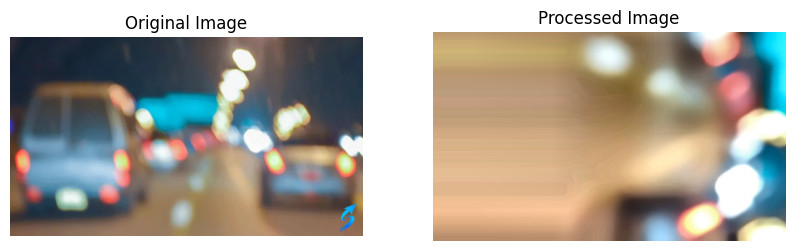

In [17]:
# Display original vs processed images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(orig3, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Processed Image')
plt.imshow(cv2.cvtColor(proc3, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [18]:
# View metadata and processing history
import pprint
pprint.pprint(result3['metadata'])

print('\nProcessing history:')
for step in result3['history']:
    print('-', step)


{'<lambda>': {'input_shape': (509, 900, 3), 'output_shape': (509, 900, 3)},
 'auto_crop': {'input_shape': (579, 1024, 3), 'output_shape': (344, 579, 3)},
 'correct_image_rotation': {'input_shape': (509, 900, 3),
                            'output_shape': (509, 900, 3)},
 'denoise_h10': {'input_shape': (509, 900, 3), 'output_shape': (509, 900, 3)},
 'hash': 'a957c7e576df09849a89be1578d5452d97ef33291deb63497ebcf9d6a8534812',
 'is_blurry': np.True_,
 'normalize_image': {'input_shape': (579, 1024, 3),
                     'output_shape': (579, 1024, 3)},
 'original_size': (509, 900, 3),
 'processed_size': (344, 579, 3),
 'resize_image': {'input_shape': (509, 900, 3), 'output_shape': (579, 1024, 3)}}

Processing history:
- correct_image_rotation applied
- denoise_h10 applied
- <lambda> applied
- resize_image applied
- normalize_image applied
- auto_crop applied
- hash computed: a957c7e5…
